<a href="https://colab.research.google.com/github/vitaldb/pyvital/blob/master/vitaldb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VitalDB 데이터 셋 이용
오픈 생체 신호 데이터셋인 VitalDB를 이용하는 모든 사용자는 반드시 아래 Data Use Agreement에 동의하여야 합니다.

https://vitaldb.net/data-bank/?query=guide&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb

동의하지 않을 경우 이 창을 닫으세요. 

## 필요한 헤더

In [8]:
import pandas as pd
import numpy as np

## 임상 정보 받아오기

In [9]:
df_cases = pd.read_csv("https://api.vitaldb.net/cases")
df_cases

caseid  casestart  caseend  ...  intraop_phe  intraop_epi  intraop_ca
0          1          0    11520  ...            0            0           0
1          2          0    15720  ...            0            0           0
2          3          0     4440  ...            0            0           0
3          4          0    21000  ...            0            0           0
4          5          0    21540  ...          900            0        2100
...      ...        ...      ...  ...          ...          ...         ...
6383    6384          0    15240  ...            0            0           0
6384    6385          0    20640  ...           30            0         300
6385    6386          0    19440  ...            0            0           0
6386    6387          0    12000  ...            0            0           0
6387    6388          0    10260  ...            0            0           0

[6388 rows x 80 columns]

## 트랙 정보 받아오기

In [10]:
df_trks = pd.read_csv("https://api.vitaldb.net/v2/trks")
df_trks

caseid                  tname                                       tid
0            1                BIS/BIS  fd869e25ba82a66cc95b38ed47110bf4f14bb368
1            1           BIS/EEG1_WAV  0aa685df768489a18a5e9f53af0d83bf60890c73
2            1           BIS/EEG2_WAV  ad13b2c39b19193c8ae4a2de4f8315f18d61a57e
3            1                BIS/EMG  2525603efe18d982764dbca457affe7a45e766a9
4            1                BIS/SEF  1c91aec859304840dec75acf4a35da78be0e8ef0
...        ...                    ...                                       ...
537092    6388     Solar8000/VENT_PIP  2d63adbc7e2653f14348e219816673cde3358cf6
537093    6388   Solar8000/VENT_PPLAT  6f6604255858ddc8f6a01b9f4774b0d43105f6da
537094    6388      Solar8000/VENT_RR  f34f3fae7fd963355c1c7060e1e876d20fa87536
537095    6388  Solar8000/VENT_SET_TV  4a4a55b8aebf9c76a4a76f62a7c1ec6fcb80e618
537096    6388      Solar8000/VENT_TV  77453bd3c4bf24ce13e577781a51929281f3b7f2

[537097 rows x 3 columns]

In [11]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & 
    set(df_cases[df_cases['age'] > 18]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid'])
)
print(len(caseids))

3452


## 트랙 ID (tid) 구하기
* caseid 와 트랙명으로부터 구한다.
* 트랙명의 리스트는 https://vitaldb.net/data-bank/?query=param

In [12]:
caseid = 6388
tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/ART_MBP')]['tid'].values[0]
tid

'8132234ea9f472b48d012f50892cd495de3871c9'

## Wave 트랙 데이터 로딩

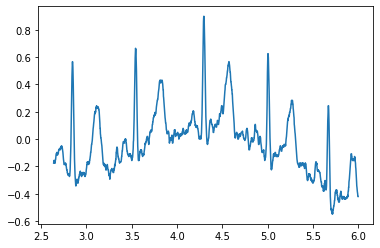

In [13]:
ecg_wav = pd.read_csv('https://api.vitaldb.net/395df4819e4e1f0d123d14f042667975f5945504').interpolate(columns=[0]).values

import matplotlib.pyplot as plt
plt.plot(ecg_wav[:3000,0], ecg_wav[:3000,1])  # 500hz

## Numeric 트랙 데이터 로딩

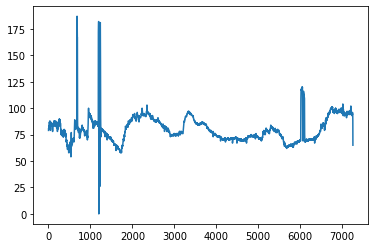

In [14]:
mbps = pd.read_csv('https://api.vitaldb.net/72a06ceb9ab1a067f3cc4be203dbeaebe69831d5').values

import matplotlib.pyplot as plt
plt.plot(mbps[:,0], mbps[:,1])

## Numeric 트랙의 정규화

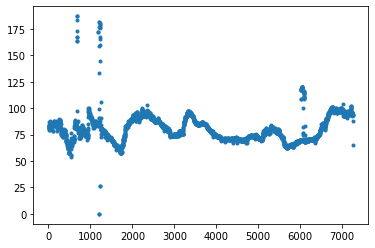

In [15]:
def load_trk(tid, interval=1):
    try:
        url = 'https://api.vitaldb.net/' + tid
        dtmbps = pd.read_csv(url).values
    except:
        return np.empty(0)
    if len(dtmbps) == 0:
        return np.empty(0)
    dtmbps[:,0] /= interval  # convert time to row
    trklen = int(np.nanmax(dtmbps[:,0])) + 1  # find maximum index (array length)
    ret = np.full(trklen, np.nan)  # create a dense array
    for idx, val in dtmbps:  # copy values
        ret[int(idx)] = val
    return ret

mbps = load_trk('72a06ceb9ab1a067f3cc4be203dbeaebe69831d5')

import matplotlib.pyplot as plt
plt.plot(np.arange(len(mbps)), mbps, '.')

## 여러 트랙을 한번에 로딩

In [16]:
def load_trks(tids, interval=1):
    trks = []
    maxlen = 0
    for tid in tids:
        trk = load_trk(tid, interval)
        trks.append(trk)
        if len(trk) > maxlen:
            maxlen = len(trk)
    if maxlen == 0:
        return np.empty(0)
    ret = np.full((maxlen, len(tids)), np.nan)  # create a dense array
    for i in range(len(tids)):  # copy values
        ret[:len(trks[i]), i] = trks[i]
    return ret

# 현 case의 트랙을 로딩
caseid = 1
sbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_SBP')]['tid'].values[0]
mbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_MBP')]['tid'].values[0]
dbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_DBP')]['tid'].values[0]
vals = load_trks([sbp_tid, mbp_tid, dbp_tid], 60)
vals

array([[ nan,  nan,  nan],
       [150., 100.,  84.],
       [177., 109.,  75.],
       [178.,  96.,  74.],
       [172., 102.,  77.],
       [172., 102.,  77.],
       [172., 134.,  85.],
       [125.,  74.,  60.],
       [107.,  76.,  65.],
       [107.,  76.,  65.],
       [107., 153.,  65.],
       [199., 145., 100.],
       [199., 145., 100.],
       [199., 145., 100.]])